In [ ]:
GMM
mu,z

In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.tri as tri
import edward as ed
import numpy as np
import tensorflow as tf
from edward.models import Categorical, MultivariateNormalDiag, Dirichlet, OneHotCategorical, MultivariateNormalFullCovariance
from functools import reduce
import time
from build_dataset import build_dataset_2dim_Kclass_gmm
from  visualize_tools import circle, ellipse, covariance_ellipse, change_aspect_ratio

In [3]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
plt.style.use('ggplot')

In [4]:
N = 600
K = 3
mean_true = [[-3.0,-3.0], [-1.0,6.0] , [5.0,-1.0]]
covariance_true = [[[1.0,0.0],[0.0,1.0]],
       [[1.0,0.0],[0.0,1.0]],
       [[1.0,0.0],[0.0,1.0]]]
mix_true  = np.array([ 1.0/3.0 , 1.0/3.0 , 1.0/3.0 ])
x_data, label,mix = build_dataset_2dim_Kclass_gmm(N,K,mean_true,covariance_true,mix_true)

<IPython.core.display.Javascript object>


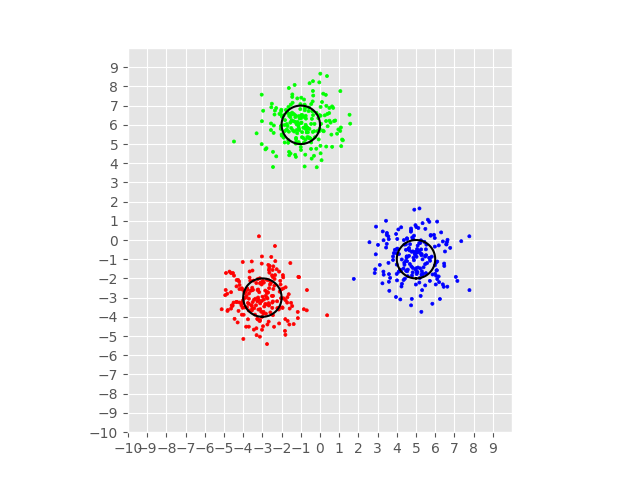

In [14]:
%matplotlib nbagg
fig = plt.figure()
ax = plt.axes([0.1,0.1,0.8,0.8])
ax.set_xlim(-10.0,10.0)
ax.set_ylim(-10.0,10.0)
plt.xticks( np.arange(-10.0, 10.0, 1.0) )
plt.yticks( np.arange(-10.0, 10.0, 1.0) )
plt.gca().set_aspect('equal', adjustable='box')
for k in range(K):
    c1,c2,ca=covariance_ellipse(covariance_true[k])
    ex,ey=ellipse(c1,c2,ca)
    plt.plot(ex+mean_true[k][0],ey+mean_true[k][1],color="black")
    #plt.plot(ex*2+mean_true[k][0],ey*2+mean_true[k][1],color="green")
    #plt.plot(ex*3+mean_true[k][0],ey*3+mean_true[k][1],color="green")
color=["#FF0000","#00FF00","#0000FF"]
area = [[5.0]*N]
for n,x in enumerate(x_data):
    plt.scatter(x[0],x[1],s=area,color=color[label[n]])
plt.savefig("ex2_dataset.png")

In [7]:
def gmm_bbvi_z_pi_mu(N,K,cov,x_data,n_iter):
    start = time.time()

    sigma = tf.constant(cov, dtype = tf.float32)

    #generative model 
    alpha = tf.constant([1.0, 1.0, 1.0])
    pi = Dirichlet(concentration = alpha)
    z = [OneHotCategorical(probs = pi, dtype = tf.float32) for n in range(N)]
    mu = [MultivariateNormalFullCovariance(loc=[0.0,0.0],covariance_matrix=[[1.0,0.0],[0.0,1.0]]) for k in range(K)]
    x = [MultivariateNormalFullCovariance(loc = sum([mu[k]*z[n][k] for k in range(K)]),covariance_matrix = sum([sigma[k]*z[n][k] for k in range(K)])) for n in range(N)]
    print("generative model")
    #variational model
    lambda_pi = tf.nn.softplus(tf.Variable([0.0 , 0.0 , 0.0]))
    qpi = Dirichlet(concentration = lambda_pi)
    y = [tf.Variable([0.0,0.0,0.0], dtype = tf.float32) for n in range(N)]
    lambda_z = [tf.nn.softmax(y[n]) for n in range(N)]
    qz = [OneHotCategorical(probs = lambda_z[n], dtype = tf.float32) for n in range(N)]
    
    lambda_m = [tf.Variable([-6.0,-6.0]) , tf.Variable([-2.0,6.0]), tf.Variable([6.0,-2.0])]
    lambda_s = [tf.nn.softplus(tf.Variable(1.5)) for k in range(K)]
    qmu = [MultivariateNormalFullCovariance(loc=lambda_m[k],covariance_matrix=lambda_s[k]*[[1.0,0.0],[0.0,1.0]]) for k in range(K)]

    
    print("variational model")
    latent_vars = {z[n]:qz[n] for n in range(N)}
    latent_vars[pi]=qpi
    for k in range(K):
        latent_vars[mu[k]] =qmu[k]
    x_ph =  [tf.placeholder(tf.float32,[2]) for n in range(N)]

    data = {x[n]:x_ph[n] for n in range(N)}
    inference = ed.KLqp(latent_vars=latent_vars,data=data)
    inference.initialize(n_iter=n_iter)
    print("inference")
    print(time.time()-start)
    sess = ed.get_session()
    tf.global_variables_initializer().run()
    loss =[]
    variational_parameter=[]
    variational_parameter.append(sess.run([lambda_pi,lambda_z,lambda_m,lambda_s]))
    for _ in range(inference.n_iter):
        info_dict = inference.update(feed_dict = {x_ph[n]:x_data[n] for n in range(N)})
        loss.append(info_dict['loss'])
        variational_parameter.append(sess.run([lambda_pi,lambda_z,lambda_m,lambda_s]))
    print(time.time()-start)
    return loss,variational_parameter                             
                                 

In [8]:
loss,variational_parameter = gmm_bbvi_z_pi_mu(N,3,covariance_true,x_data,5000)

generative model
variational model
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

inference
393.2139506340027
2439.2685787677765


<IPython.core.display.Javascript object>


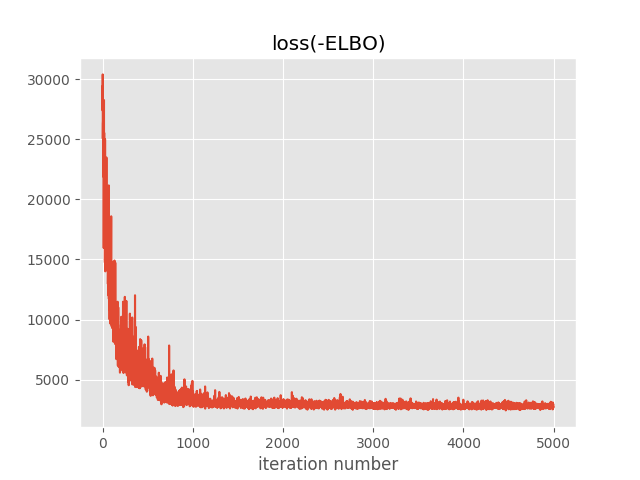

In [9]:
%matplotlib nbagg
plt.title("loss(-ELBO)")
plt.plot(loss)
plt.xlabel("iteration number")
plt.show()

<IPython.core.display.Javascript object>


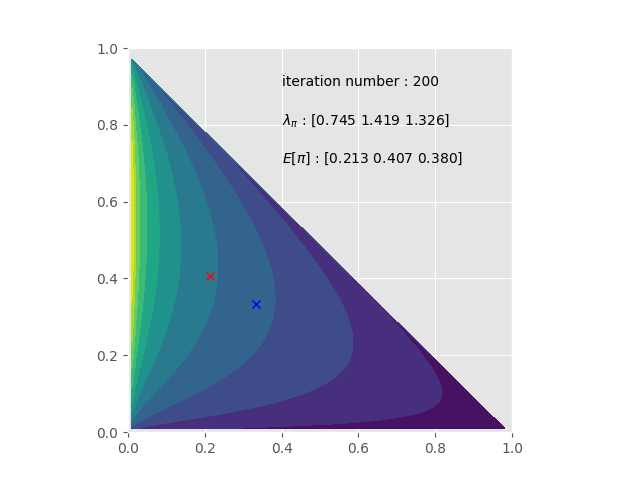

In [11]:
%matplotlib nbagg
import scipy.stats as ss
import matplotlib.tri as mtri
from matplotlib import cm
fig = plt.figure()
ax = plt.axes([0.1,0.1,0.8,0.8])
ax.set_xlim(0.0,1.0)
ax.set_ylim(0.0,1.0)
plt.gca().set_aspect('equal', adjustable='box')
X = []
Y = []

for x in np.arange(0.01,0.99,0.01):
    for y in  np.arange(0.01,0.99-x,0.01):
        X.append(x)
        Y.append(y)
triang = mtri.Triangulation(X, Y)

plt.plot(mix_true[0],mix_true[1],"bx")
artists = []
for t,vp in enumerate(variational_parameter):
    if t %100 == 0:
        dc = ss.dirichlet(np.array(vp[0]))
        
        Z = []
        for x,y in zip(X,Y):
            Z.append(dc.pdf((x,y)))

        sum_pi = vp[0][0]+vp[0][1]+vp[0][2]
        exp = vp[0]/sum_pi
            
        text = [plt.text(0.4,0.9,"iteration number : "+str(t)),
                    plt.text(0.4,0.8,"$\lambda_\pi$ : ["+"{0:.3f}".format(vp[0][0]) + " {0:.3f}".format(vp[0][1]) + " {0:.3f}]".format(vp[0][2])),
                    plt.text(0.4,0.7,"$E[\pi]$ : ["+"{0:.3f}".format(exp[0]) + " {0:.3f}".format(exp[1]) + " {0:.3f}]".format(exp[2]))]

        im_pi = ax.tricontourf(triang, Z,10)
        

        e = plt.plot(exp[0],exp[1],"rx")
        
        artists.append(im_pi.collections+text+e)
ani=animation.ArtistAnimation(fig,artists)
#plt.show()
ani.save("ex2_gmm_2dim_3class_pi.gif", writer='imagemagick', fps=4)

<IPython.core.display.Javascript object>


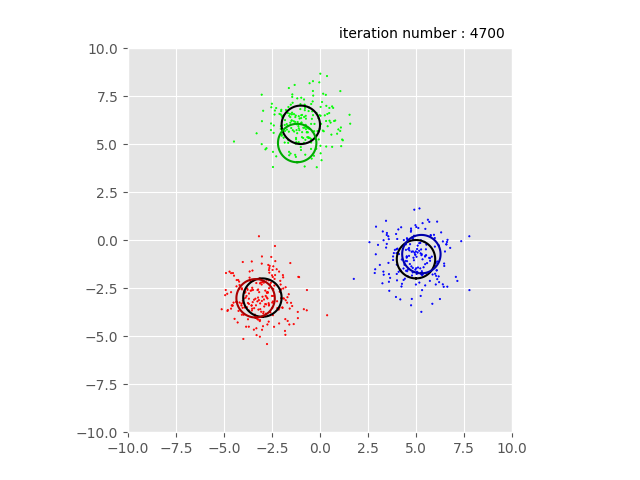

In [13]:
%matplotlib nbagg
fig = plt.figure()
ax = plt.axes([0.1,0.1,0.8,0.8])
ax.set_xlim(-10.0,10.0)
ax.set_ylim(-10.0,10.0)
plt.gca().set_aspect('equal', adjustable='box')
for k in range(K):
    c1,c2,ca=covariance_ellipse(covariance_true[k])
    ex,ey=ellipse(c1,c2,ca)
    plt.plot(ex+mean_true[k][0],ey+mean_true[k][1],color="black")
artists = []
area = [[1.0]*N]
for t,vp in enumerate(variational_parameter):
    if t % 100 == 0 :
        text = [plt.text(1.0,10.5,"iteration number : "+str(t))]
        im_z=plt.scatter(x_data.T[0],x_data.T[1],s=area,color=vp[1])
        g = []
        c1,c2,ca=covariance_ellipse(covariance_true[0])
        ex,ey=ellipse(c1,c2,ca)
        g.append(plt.plot(ex+vp[2][0][0],ey+vp[2][0][1],color="#AA0000"))
        g.append(plt.plot(ex+vp[2][1][0],ey+vp[2][1][1],color="#00AA00"))
        g.append(plt.plot(ex+vp[2][2][0],ey+vp[2][2][1],color="#0000AA"))
        artists.append([im_z]+text+g[0]+g[1]+g[2])
ani=animation.ArtistAnimation(fig,artists)
plt.show()
ani.save("ex2_gmm_2dim_3class_z_mu.gif", writer='imagemagick', fps=4)